# Stock Price Forecasting: Feature Engineering, EDA & Feature Selection<br>(Part 1)

**Notebook Content:**
1. Data Collection & Preprocessing
2. Outlier Detection
3. Feature Engineering
4. Exploratory Data Analysis
5. Feature Selection

### 1. Data Collection & Preprocessing

The first step will be collecting daily price data (stock prices). We will download free data from Yahoo! Finance, which has several decades of data available for most exchanges. The data will contain six basic prices: open, high, low, close, adjusted close, volume, and an index date column in YYYY-MM-DD format. Currency is in USD (US Dollar) [Yahoo!](https://finance.yahoo.com/quote/MTD/).

In this project we will focus on forecasting the **close** prices. The company of choice will be Mettler-Toledo International Inc. listed on the New York Stock Exchange (ticker symbol: MTD).

In [1]:
#pip install yfinance

from yfinance import download
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set plotting style
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 9

# fetch Yahoo! stock prices for Mettler-Toledo
df = download('MTD', interval='1d', period='max', progress=False).reset_index()

# reset header
df.columns = df.columns.str.lower()
df.rename(columns={'adj close': 'adj_close'}, inplace=True)

df.set_index('date', inplace=True)

df.tail(10)

,open,high,low,close,adj_close,volume
date,,,,,,
2024-02-15,1183.050049,1200.709961,1182.270020,1192.699951,1192.699951,95100
2024-02-16,1189.209961,1202.510010,1186.780029,1187.439941,1187.439941,80400
2024-02-20,1177.959961,1196.569946,1176.770020,1184.369995,1184.369995,144000
2024-02-21,1177.300049,1196.709961,1177.300049,1193.890015,1193.890015,93200
2024-02-22,1195.000000,1200.550049,1174.589966,1192.780029,1192.780029,136900
2024-02-23,1200.400024,1212.969971,1200.400024,1209.790039,1209.790039,67800
2024-02-26,1206.410034,1215.000000,1195.260010,1195.260010,1195.260010,90200
2024-02-27,1205.239990,1221.780029,1200.079956,1213.209961,1213.209961,104900
2024-02-28,1213.209961,1252.459961,1213.209961,1243.569946,1243.569946,118800


Dataset description:
* `open` column contains the opening prices of the index on that day;
* `high` and `low` columns contain the highest and lowest prices during the trading day;
* `close` column contains the closing price of the index on that day;
* `adj_close` column contains the closing prices adjusted for dividends and stock splits;
* the stock's `volume` is the number of shares traded in a given period.

In [2]:
# are close prices adjusted by dividends and stock splits?
(df['close'] == df['adj_close']).value_counts(False).all()

True

All close prices are equal to adjusted prices which means that including dividends and stock splits in the dataset does not make any sense. Since these two features are identical, adjusted price component will be dropped.

In [3]:
# drop column
del df['adj_close']

# are there no duplicated rows?
df.duplicated().value_counts(False).all()

True

In [4]:
def columns_summary():
    '''
    Returns number of nulls and data type.
    '''
    df_sum = pd.DataFrame()
    df_sum['Feature'] = df.columns.to_list()
    df_sum['Nulls'] = df.isnull().sum().to_list()
    df_sum['Data Type'] = df.dtypes.to_list()
    
    return df_sum.style.hide(axis='index')

columns_summary()

Feature,Nulls,Data Type
open,0,float64
high,0,float64
low,0,float64
close,0,float64
volume,0,int64


Not all dates are included in the dataframe. These missing records are most likely not trading days (weekends, holidays, etc.). We will add these rows and fill missing values using linear interpolation, which is a simple and reasonable method for time series data.

In [5]:
df = df.asfreq(freq='D', normalize=False).interpolate(method='linear', limit_direction=None)
df = df.astype({'volume': 'int32'})
df.head()

,open,high,low,close,volume
date,,,,,
1997-11-14,14.0625,15.250000,14.0625,14.875,2233500
1997-11-15,14.6250,15.416667,14.3750,15.000,1660666
1997-11-16,15.1875,15.583333,14.6875,15.125,1087833
1997-11-17,15.7500,15.750000,15.0000,15.250,515000
1997-11-18,15.4375,15.500000,15.0000,15.000,257300


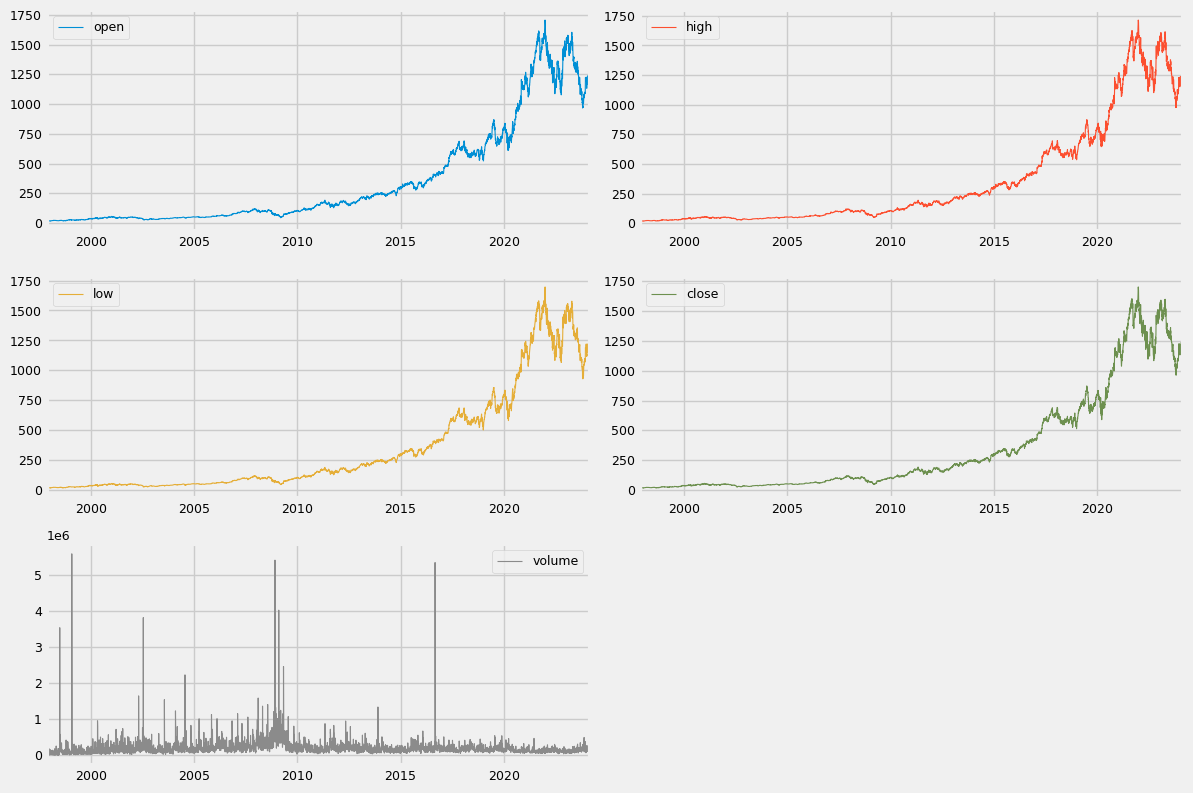

In [6]:
# plot each stock price
df.plot(kind='line', subplots=True, title=None, xlabel='', layout=(3, 2), sharex=False, sharey=False, figsize=(12, 8))
plt.tight_layout()

plt.show()

### 2. Outlier Detection

We will extract outliers for each variable except `volume`. We will apply a Z-score test to find these observations and modify them to be the mean of the 50 values that come before it (rolling window size). Commonly for identifying outliers we set a threshold of Z-scores greater than 3.

We need to keep in mind that extreme values are sometimes exceptable, due to market crashes and other external factors (pandemics, politics, wars).

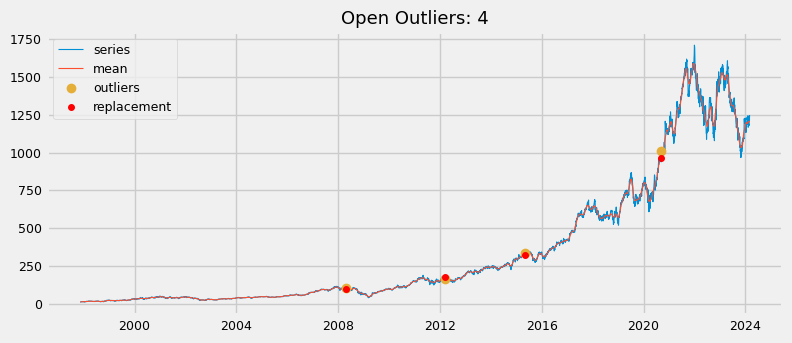

In [7]:
def z_score(series, window_size, threshold=3, return_all=False):
    '''
    Detects outliers with Z-score test.
    '''
    rolling = series.rolling(window=window_size, min_periods=1, center=True)
    avg = rolling.mean()
    std = rolling.std(ddof=0)
    z = series.sub(avg).div(std)   
    mean = z.between(-threshold, threshold)
    
    if return_all:
        return z, avg, std, mean
    
    return series.where(mean, avg)

# =================================================
# perform example on 'open' prices and plot results
z, avg, std, mean = z_score(df['open'], window_size=50, threshold=3, return_all=True)

plt.figure(figsize=(8, 3.5), tight_layout=True)

plt.plot(df['open'], label='series')
plt.plot(avg, label='mean')
plt.plot(df.loc[~mean, 'open'], label='outliers', marker='o', linestyle='')
plt.plot(avg[~mean], label='replacement', marker='o', linestyle='', color='red', markersize=4)
plt.title('Open Outliers: ' + str(len(avg[~mean])))
plt.legend()
plt.show()

In [8]:
# replace outliers with means
for i in ['open', 'high', 'low', 'close']:
    z, avg, std, mean = z_score(df[i], window_size=50, threshold=3, return_all=True)
        
    df.loc[~mean, i] = avg[~mean]

### 3. Feature Engineering

To enrich the dataset, capture more information and patterns, we will perform feature augmentation and add new exogenous  features. This should improve the model training and predicting process. In case of stock prices, we can apply differencing, trend indicators, rolling or transformations (percentile, Z-score, logarithm, etc.). Implementing technical indicators are also forms of feature engineering. For this notebook the following features will be introduced:

* extract **year**, **month**, **day**, **quarter**, **weekday** (Monday as 1, Tuesday as 2, Wednesday as 3,...) from each date;
* **month end**: this feature will check whether or not the date was the last day of the month;

* timestamp expressed in **UNIX format**: the number of seconds calculated since January 1st, 1970 00:00:00 UTC;

* **holiday**: this feature will check whether or not the day was a US holiday;

* **daily variation**: the difference between the high and low prices, divided by the open price, this feature will represent the volatility of the index on that day;

* **logs**: many times values like market capitalization, volume, revenue can provide better prediction target if transformed into log space - this operation will be applied for volume;

* **average true range (ATR)**: this feature will measure the volatility of the index over time (from a 14-day window);

* **directional movement index (DMI)**: this feature will measure the positive and negative movements of the index (from a 14-day window);

* **average directional index (ADX)**: this feature will measure the strength and direction of the trend of the index (from a 14-day window);

* **daily return**: expressed by percentage change in the close price from the previous day’s close price, this feature will represent the performance of the index on that day;

* **high - close**: the difference between the high and close prices, divided by the open price, this feature will represent the downward pressure on the index on that day;

* **low - open**: the difference between the low and open prices, divided by the open price, this feature will represent the upward pressure on the index on that day;

* **moving average convergence divergence (MACD)**: calculated from a 12-day EMA and a 26-day EMA of close % change, this technical indicator measures the trend and momentum of an asset;

* **cycle**: the smoothed values of close prices applied with a Hodrick-Prescott (HP) filter, this feature separate the trend from the business cycle;

* **7-day simple moving average (SMA) of close prices**: this feature will represent the short-term trend of the index;

* **14-day exponential moving average of close prices**: this feature will represent a smoother and more responsive version of the SMA;

* **7-day standard deviation (STD) of the close prices**: this feature represents the short-term variability of the index;

* **7-day cumulative moving average (CMA) of close prices**: this feature describes the moving average of all data up to the current data point;

* **7-day SMA minus 2 STD**: the 7-day SMA minus two times the 7-day STD, this feature will represent the lower bound of a confidence interval for the index;

* **7-day SMA plus 2 STD**: similar to previous feature, this will represent the upper bound of a confidence interval for the index;

* **close change**: the difference between the close and previous day's close prices;

* **relative strength index (RSI)**: this feature is a popular technical indicator that measures the momentum and overbought/oversold conditions of an asset (from a 14-day window);

* **stochastic oscillator (%K & %D)**: this indicator compares the close price with the high and low prices over a 14-day window - this variable measures the position of the index relative to its recent range;

* **William's %R (William's percent range)**: is a type of momentum indicator that moves between 0 and -100 and measures overbought and oversold levels, calculated from a 14-day window;

* **cumulative change**: expressed in percentage by dividing the cumulative sum of close prices by the sum of all close prices multiplyed by 100, this feature will represent the long-term performance of the index;

* **commodity channel index**: is a momentum-based oscillator used to help determine when an investment vehicle is reaching a condition of being overbought or oversold, this feature assess price trend direction and strength;

* **market capitalization of close prices**: the total value of a company based on their close price multiplied by the shares outstanding (volume), this feature will also display the number of transactions;

* **percentage price oscillator (PPO)**: is a technical indicator that shows the relationship between two moving averages in percentage terms, this feature is used to compare asset performance and volatility, and help comfirm trend direction.

In [9]:
#df['date'] = df.index.date
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['quarter'] = df.index.quarter
df['weekday'] = df.index.dayofweek + 1
df['month_end'] = df.index.is_month_end.astype('int32')
df['unix'] = df.index.astype('int64') // 10**9
df = df.assign(daily_variation=lambda x: (x['high'] - x['low'])/ x['open'])
df = df.assign(logs=lambda x: x['volume'].apply(np.log))

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar as us_calendar

def holidays(df):
    '''
    Function computes binary holiday feature.
    '''
    start_date = df.index.min()
    end_date = df.index.max()
    holidays = us_calendar().holidays(start=start_date, end=end_date)

    df['holiday'] = df.index.isin(holidays).astype('int32')

holidays(df)

In [11]:
def trend_indicators(df, period=14):
    '''
    Computes trend indicators: ATR (average true range), DMI (directional movement index), ADX (average directional index).
    '''
    alpha = 1 / period

    # TR (true range)
    df['H-L'] = df['high'] - df['low']
    df['H-C'] = np.abs(df['high'] - df['close'].shift(1))
    df['L-C'] = np.abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
    del df['H-L'], df['H-C'], df['L-C']

    # ATR (average true range)
    df['ATR'] = df['TR'].ewm(alpha=alpha, adjust=False).mean()

    # +DX & -DX
    df['H-pH'] = df['high'] - df['high'].shift(1)
    df['pL-L'] = df['low'].shift(1) - df['low']
    df['+DX'] = np.where((df['H-pH'] > df['pL-L']) & (df['H-pH'] > 0), df['H-pH'], 0.0)
    df['-DX'] = np.where((df['H-pH'] < df['pL-L']) & (df['pL-L'] > 0), df['pL-L'], 0.0)
    del df['H-pH'], df['pL-L']

    # DMI (directional movement index)
    df['S+DM'] = df['+DX'].ewm(alpha=alpha, adjust=False).mean()
    df['S-DM'] = df['-DX'].ewm(alpha=alpha, adjust=False).mean()
    df['+DMI'] = (df['S+DM']/ df['ATR']) * 100
    df['-DMI'] = (df['S-DM']/ df['ATR']) * 100
    df['DMI'] = 100 * np.abs(df['+DMI'] - df['-DMI'])/ np.abs(df['+DMI'] + df['-DMI'])
    del df['S+DM'], df['S-DM']

    # ADX (average directional index)
    df['DX'] = (np.abs(df['+DMI'] - df['-DMI']) /(df['+DMI'] + df['-DMI'])) * 100
    df['ADX'] = df['DX'].ewm(alpha=alpha, adjust=False).mean()
    del df['DX'], df['TR'], df['-DX'], df['+DX'], df['+DMI'], df['-DMI']
    
    df.columns = df.columns.str.lower()

trend_indicators(df)

In [12]:
df = df.assign(ema_14=lambda x: x['close'].ewm(span=14, adjust=False).mean())
df = df.assign(cma_7=lambda x: x['close'].expanding(7).mean())
df = df.assign(std_7=lambda x: x['close'].rolling('7D').std())
df = df.assign(daily_return=lambda x: (x['close'] /x['close'].shift()) - 1) # or x['close'].pct_change(periods=1)
df = df.assign(high_close=lambda x: (x['high'] - x['close'])/ x['open'])
df = df.assign(low_open=lambda x: (x['low'] - x['open'])/ x['open'])

In [13]:
from statsmodels.tsa.filters.hp_filter import hpfilter

def hp_filter(df):
    '''
    Computes cycle smoothed with Hodrick-Prescott filter.
    '''
    # for daily data
    lambda_ = 1600*(365/4)**4
    cycle = pd.Series(hpfilter(df['close'], lamb=lambda_)[0], name='cycle')
    
    df = df.join(cycle)
    
    return df

df = hp_filter(df)

In [14]:
def macd(df, short_period=12, long_period=26, signal_period=9):
    '''
    Computes MACD (moving average convergence divergence) indicator.
    '''
    # 12-period EMA
    EMA_12 = df['close'].ewm(span=short_period, adjust=False).mean()
    # 26-period EMA
    EMA_26 = df['close'].ewm(span=long_period, adjust=False).mean()
    
    # MACD
    MACD = pd.Series(EMA_12 - EMA_26, name='macd')
    
    # optionally: signal line (9-period EMA of MACD)
    MACD_signal = pd.Series(MACD.ewm(span=signal_period, adjust=False).mean(), name='macd_signal')
    
    df = df.join(MACD)
    #df = df.join(MACD_signal)
    
    return df

df = macd(df)

In [15]:
def bollinger_bands(df, n=20, m=2):
    '''
    Computes Bollinger bands.
    '''
    # typical price
    TP = (df['high'] + df['low'] + df['close']) /3
    
    # Bollinger bands
    B_MA = pd.Series((TP.rolling(n, min_periods=n).mean()), name='b_ma')
    sigma = TP.rolling(window=n, min_periods=n).std()
    
    BL = pd.Series(B_MA - m * sigma, name='bl')
    BU = pd.Series(B_MA + m * sigma, name='bu')
    
    df = df.join(B_MA)
    df = df.join(BL)
    df = df.join(BU)
    
    return df

df = bollinger_bands(df)

In [16]:
def sma(df):
    '''
    Computes SMA (simple moving averages) over a 7-day window & its confidence intervals.
    '''
    # 7-period EMA
    SMA_7 = pd.Series(df['close'].rolling('7D').mean(), name='sma_7')
    
    # confidence intervals
    interval = 2 * df['close'].rolling('7D').std()
    SMA_7_upper = pd.Series(SMA_7 + interval, name='sma_7_up')
    SMA_7_lower = pd.Series(SMA_7 - interval, name='sma_7_low')
    
    df = df.join(SMA_7)
    df = df.join(SMA_7_upper)
    df = df.join(SMA_7_lower)
    
    return df

df = sma(df)

In [17]:
# close-change
df = df.assign(close_change=lambda x: x['close'] - x['close'].shift())

In [18]:
def rsi(df, period=14):
    '''
    Computes RSI (relative strength index).
    '''
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = - delta.where(delta < 0, 0)
    
    # sum of average gains
    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    # sum of average losses
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    RS = avg_gain / avg_loss
    RSI = pd.Series(100 - (100 / (1 + RS)), name='rsi')
    
    df = df.join(RSI)
    
    return df

df = rsi(df)

In [19]:
def stochastic_oscillator(df, k_period=14, d_period=3):
    '''
    Computes stochastic oscillator: %K & %D.
    '''
    # max value of previous 14 periods
    max_high = df['high'].rolling(k_period).max()
    # min value of previous 14 periods
    min_low = df['low'].rolling(k_period).min()
    
    # uses the min/max values to calculate the %K (as a percentage)
    K = pd.Series((df['close'] - min_low) * 100 / (max_high - min_low), name='k')
    # uses the %K to calculates a SMA over the past 3 values of %K
    D = pd.Series(K.rolling(d_period).mean(), name='d')
    
    df = df.join(K)
    df = df.join(D)
    
    return df

df = stochastic_oscillator(df)

In [20]:
def williams_r(df, period=14):
    '''
    Computes William's %R indicator.
    '''
    # max value of previous 14 periods
    max_high = df['high'].rolling(period).max()
    # min value of previous 14 periods
    min_low = df['low'].rolling(period).min()
    
    wr = -100 * ((max_high - df['close']) / (max_high - min_low))
    WR = pd.Series(wr, name='wr')
                                             
    df = df.join(WR)                                        
    
    return df

df = williams_r(df)

In [21]:
# cumulative change
df = df.assign(cum_change=lambda x: (100 * x['close'].cumsum())/ x['close'].sum())

In [22]:
def cci(df, period=14):
    '''
    Computes CCI (commodity channel index).
    '''
    # typical price
    TP = (df['high'] + df['low'] + df['close']) /3
    SMA = TP.rolling(period).mean()
    MAD = TP.rolling(period).std()
    
    cci = (TP - TP.rolling(period).mean()) /(0.015 * MAD)
    CCI = pd.Series(cci, name='cci')
    
    df = df.join(CCI)
    
    return df

df = cci(df)

In [23]:
# market capitalization
df = df.assign(market_cap=lambda x: x['close'] * x['volume'])

In [24]:
def ppo(df, short_period=12, long_period=26, signal_period=9):
    '''
    Computes PPO (percentage price oscillator).
    '''
    # 12-period EMA
    EMA_12 = df['close'].ewm(span=short_period, adjust=False).mean()
    # 26-period EMA
    EMA_26 = df['close'].ewm(span=long_period, adjust=False).mean()
    
    # PPO
    PPO = pd.Series(100 *(EMA_12 - EMA_26) /EMA_26, name='ppo')
    
    # optionally: signal line (9-period EMA of PPO)
    PPO_signal = pd.Series(PPO.ewm(span=signal_period, adjust=False).mean(), name='ppo_signal')
    
    df = df.join(PPO)
    #df = df.join(PPO_signal)
    
    return df

df = ppo(df)

In [25]:
# display new header
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'year', 'month', 'day',
       'quarter', 'weekday', 'month_end', 'unix', 'daily_variation', 'logs',
       'holiday', 'atr', 'dmi', 'adx', 'ema_14', 'cma_7', 'std_7',
       'daily_return', 'high_close', 'low_open', 'cycle', 'macd', 'b_ma', 'bl',
       'bu', 'sma_7', 'sma_7_up', 'sma_7_low', 'close_change', 'rsi', 'k', 'd',
       'wr', 'cum_change', 'cci', 'market_cap', 'ppo'],
      dtype='object')

### 4. Exploratory Data Analysis

We will perform some basic EDA to visualize our new features. We will search for any patterns throughout the historical data.

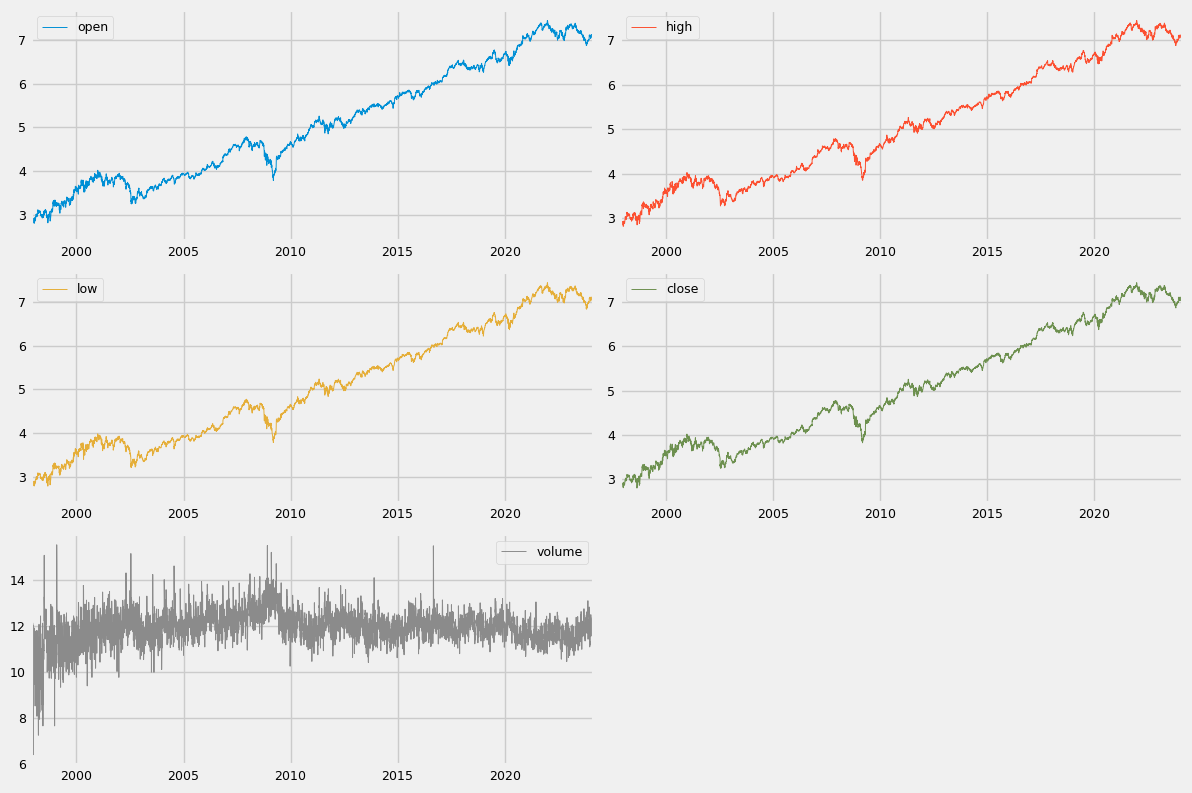

In [26]:
# apply natural logarithm function
df[['open', 'high', 'low', 'close', 'volume']].apply(np.log).plot(kind='line', subplots=True,
                        linewidth=0.7, title=None, xlabel='', layout=(3, 2), sharex=False, sharey=False, figsize=(12, 8))
plt.tight_layout()
    
plt.show()

We can observe constant price growth throughout the whole time series.

In [27]:
# aggregate prices per year
df_agg = pd.DataFrame()

for year in df['year'].unique():
    year_open  = df.loc[df['year'] == year, 'open'][0]
    year_close = df.loc[df['year'] == year, 'close'][-1]
    year_low   = df.loc[df['year'] == year, 'low'].min()
    year_high  = df.loc[df['year'] == year, 'high'].max()
    
    df_agg[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_agg = df_agg.T
df_agg = df_agg.set_axis(['open', 'close', 'low', 'high'], axis=1)

# percentage change between the open and close price of the year
df_agg = df_agg.assign(year_change=lambda x: 100 * (x['close'] - x['open'])/ x['open'])
df_agg.head()

,open,close,low,high,year_change
1997,14.062500,17.250000,14.0625,18.750000,22.666667
1998,17.375000,28.062500,16.2500,28.937500,61.510791
1999,27.984375,38.187500,20.8750,39.500000,36.460078
2000,37.750000,53.187500,30.0000,56.000000,40.894040
2001,54.093750,51.849998,36.5000,54.203125,-4.147894


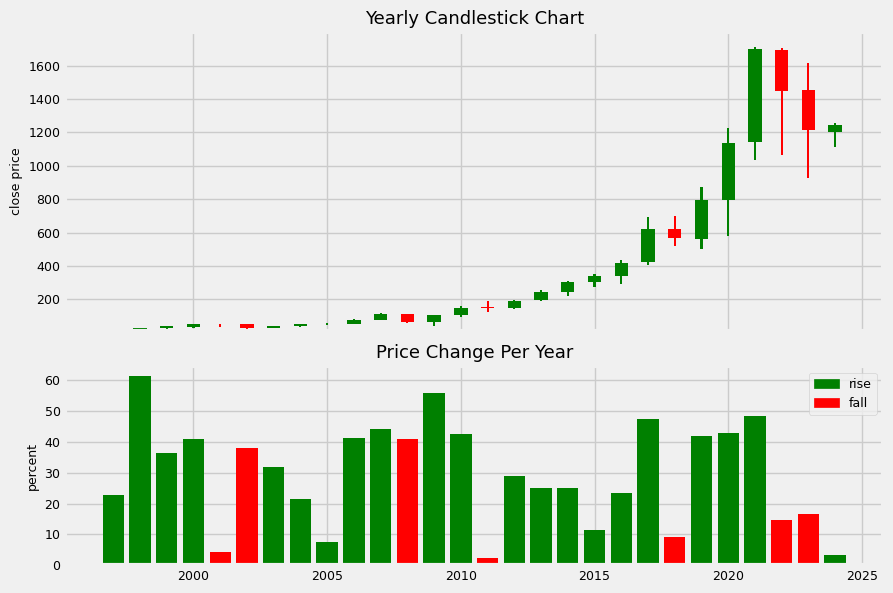

In [28]:
# 'up' dataframe will store the stock prices
# when the closing stock price is greater than or equal to the opening stock prices
up = df_agg.query('`close` >= `open`')

# 'down' dataframe will store the stock prices
# when the closing stock price is lesser than the opening stock prices
down = df_agg.query('`close` < `open`')

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 1]})

# candlestick plot for yearly data
# up prices of the stock
axes[0].bar(x=up.index, height=up['close']-up['open'], width=0.5, bottom=up['open'], color='green')
axes[0].bar(x=up.index, height=up['high']-up['close'], width=0.08, bottom=up['close'], color='green')
axes[0].bar(x=up.index, height=up['low']-up['open'], width=0.08, bottom=up['open'], color='green')
axes[0].set(title='Yearly Candlestick Chart', ylabel='close price')

# down prices of the stock
axes[0].bar(x=down.index, height=down['close']-down['open'], width=0.5, bottom=down['open'], color='red')
axes[0].bar(x=down.index, height=down['high']-down['open'], width=0.08, bottom=down['open'], color='red')
axes[0].bar(x=down.index, height=down['low']-down['close'], width=0.08, bottom=down['close'], color='red')

# plot percentage price change
colors_ = ['red' if (bar < 0) else 'green' for bar in df_agg['year_change']]

# legend settings
mask_colors = {'rise': 'green', 'fall': 'red'}
labels = list(mask_colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=mask_colors[label]) for label in labels]

axes[1].bar(x=df_agg.index, height=np.abs(df_agg['year_change']), color=colors_)
axes[1].set(title='Price Change Per Year', ylabel='percent')
axes[1].legend(handles, labels)

plt.show()

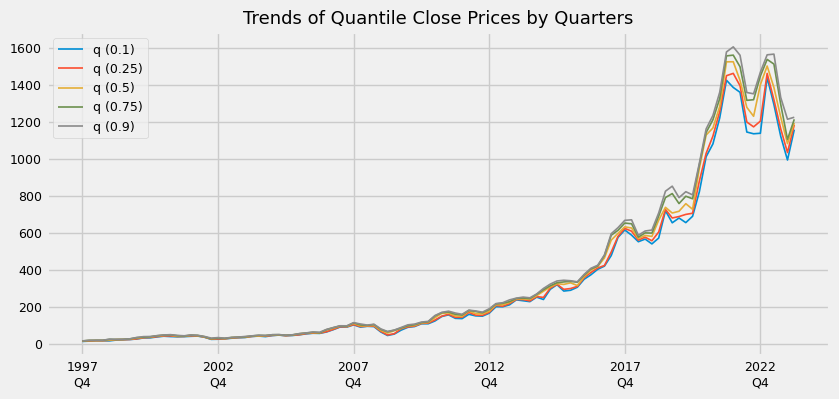

In [29]:
# date in YYYY-QQ format
year_quarter = lambda x: x['year'].astype(str) + '\nQ' + x['quarter'].astype(str)

# close price plot for different quantiles
plt.figure(figsize=(9, 4))

for i in [0.1, 0.25, 0.5, 0.75, 0.9]:
    df.groupby(year_quarter(df))['close'].quantile(i).plot(label='q ({})'.format(i), linewidth=1.2)
    
plt.title('Trends of Quantile Close Prices by Quarters')
plt.xlabel(None)
plt.legend()

plt.show()

The quantiles returned smoother trend lines and display how the market falls and rise again. Higher quantile prices have increased with time and lower quantile prices decreased. It is easier to spot serious stock price drops on the market. First significant crash started at 2020 due to the global COVID-19 pandemic. The second financial decline was in 2022 due to the Russian invasion of Ukraine and fears of economic recession.

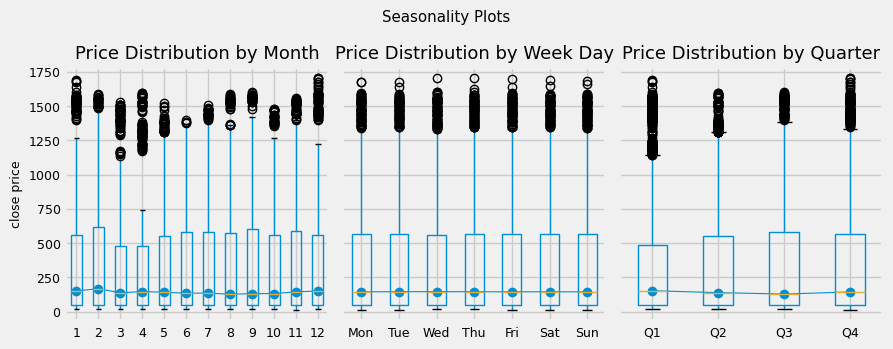

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5), sharex=False, sharey=True, tight_layout=True)
axes = axes.ravel()

# price distribution by month
df.boxplot(column='close', by='month', ax=axes[0])
df.groupby('month')['close'].median().plot(style='o-', linewidth=0.8, ax=axes[0])
axes[0].set(title='Price Distribution by Month', xlabel=None, ylabel='close price')

# price distribution by week day
df.boxplot(column='close', by='weekday', ax=axes[1])
df.groupby('weekday')['close'].median().plot(style='o-', linewidth=0.8, ax=axes[1])
axes[1].set(title='Price Distribution by Week Day', xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            xlabel=None)

# price distribution by year quarter
df.boxplot(column='close', by='quarter', ax=axes[2])
df.groupby('quarter')['close'].median().plot(style='o-', linewidth=0.8, ax=axes[2])
axes[2].set(title='Price Distribution by Quarter', xticklabels=['Q1', 'Q2', 'Q3', 'Q4'], xlabel=None)

fig.suptitle('Seasonality Plots')
plt.show()

There are patterns for trade in terms of months and quarters. The day of week seems to not have any impact on prices.

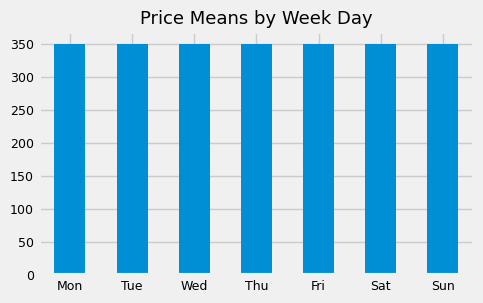

In [31]:
fig, axes = plt.subplots(figsize=(5, 3))

# close price means for each week day
df.groupby(['weekday'])['close'].mean().plot(kind='bar')
axes.set(title='Price Means by Week Day', xlabel=None)
axes.set_xticklabels(labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

plt.show()

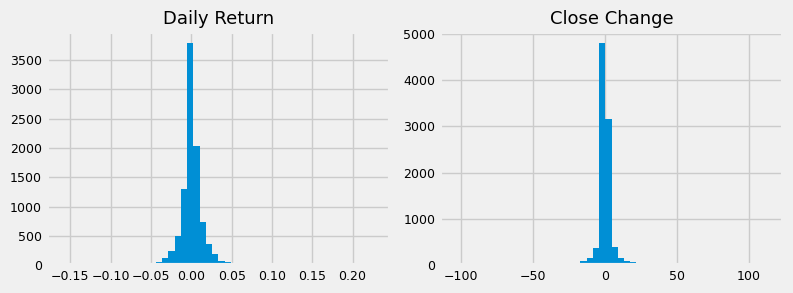

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

axes[0].hist(df['daily_return'], bins=50)
axes[0].set_title('Daily Return')

axes[1].hist(df['close_change'], bins=50)
axes[1].set_title('Close Change')

plt.show()

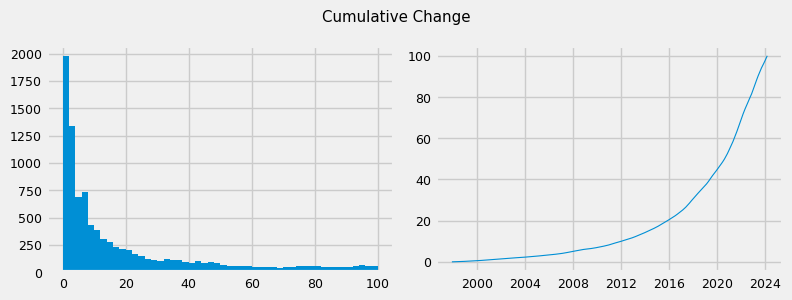

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)
fig.suptitle('Cumulative Change')

axes[0].hist(df['cum_change'], bins=50)

axes[1].plot(df['cum_change'])

plt.show()

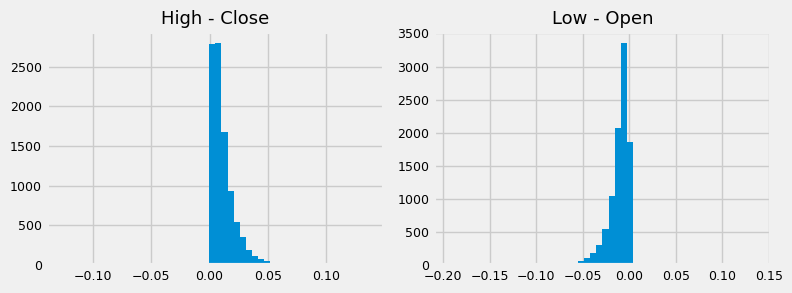

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

axes[0].hist(df['high_close'], bins=50)
axes[0].set_title('High - Close')

axes[1].hist(df['low_open'], bins=50)
axes[1].set_title('Low - Open')

plt.show()

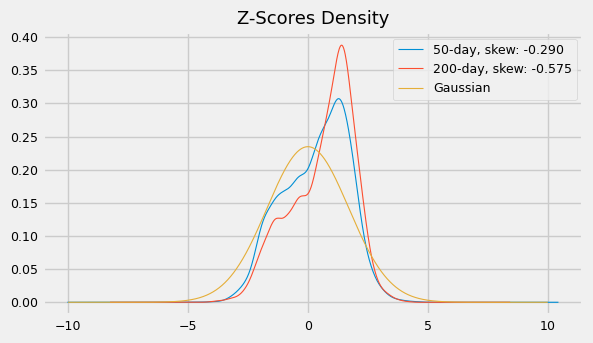

In [35]:
zscore_den = lambda x, m, n: (x['close'] - x['close'].rolling(window=m, min_periods=n).mean())\
               / x['close'].rolling(window=m, min_periods=n).std()

from scipy.stats import norm

# plot close price distribution after applying Z-score over 50-day & 200-day windows
plt.figure(figsize=(6, 3.5), tight_layout=True)

x_axis = np.arange(-10, 10, 0.001)

zscore_den(df, m=50, n=5).plot.kde(label='50-day, skew: {:.3f}'.format(zscore_den(df, m=50, n=5).skew()))
zscore_den(df, m=200, n=20).plot.kde(label='200-day, skew: {:.3f}'.format(zscore_den(df, m=200, n=20).skew()))
plt.plot(x_axis, norm.pdf(x_axis, loc=0, scale=1.7), label='Gaussian')
plt.title('Z-Scores Density')
plt.ylabel(None)
plt.legend()

plt.show()

The close price distribution for over both windows is near normal distribution (slight negative skew) which is a good sign - predicting prices should be possible.

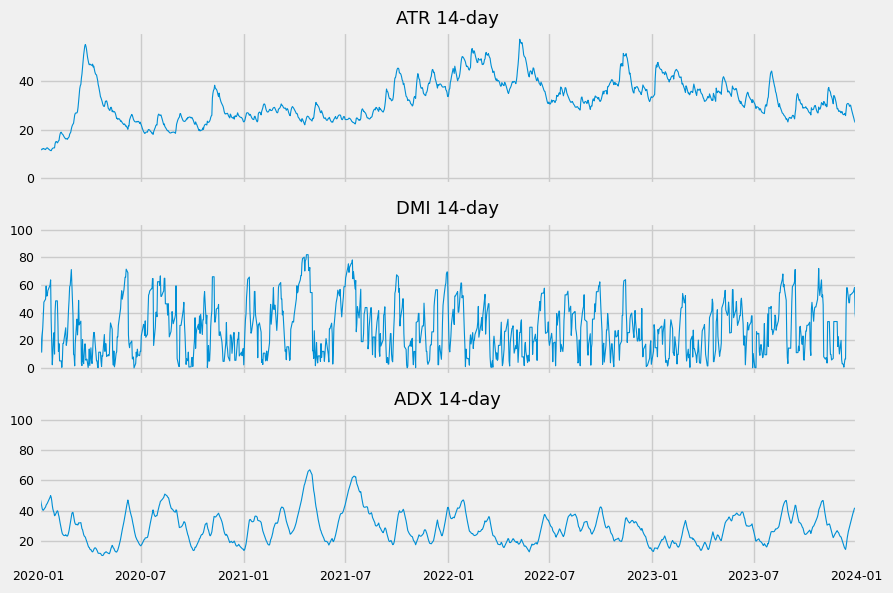

In [36]:
# ATR, DMI, ADX over 4 year period
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [2, 2, 2]})

# ATR over 14-day
axes[0].plot(df['atr'])
axes[0].set(title='ATR 14-day')
axes[0].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-01-01'))

# DMI over 14-day window
axes[1].plot(df['dmi'])
axes[1].set(title='DMI 14-day')

# ADX over 14-day window
axes[2].plot(df['adx'])
axes[2].set(title='ADX 14-day')

plt.show()

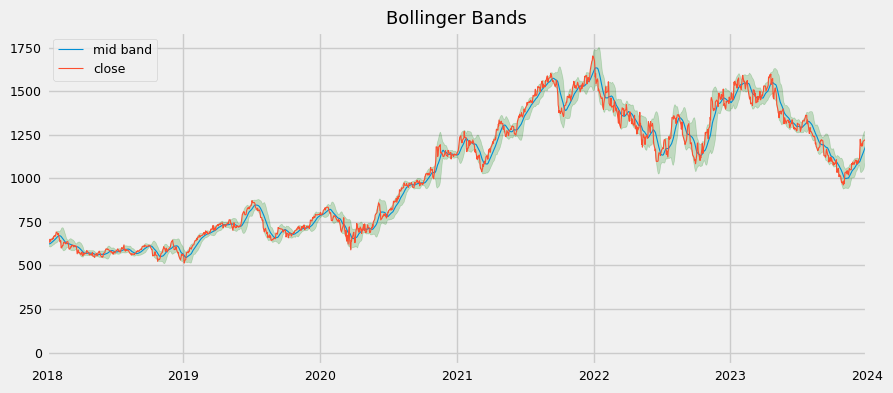

In [37]:
# Bollinger bands for 6 year period
plt.figure(figsize=(9, 4), tight_layout=True)

df['b_ma'].plot(label='mid band')
df['close'].plot(label='close')
plt.fill_between(df.index, df['bu'], df['bl'], color='green', alpha=0.2)
plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2024-01-01'))
plt.title('Bollinger Bands')
plt.xlabel(None)
plt.legend()

plt.show()

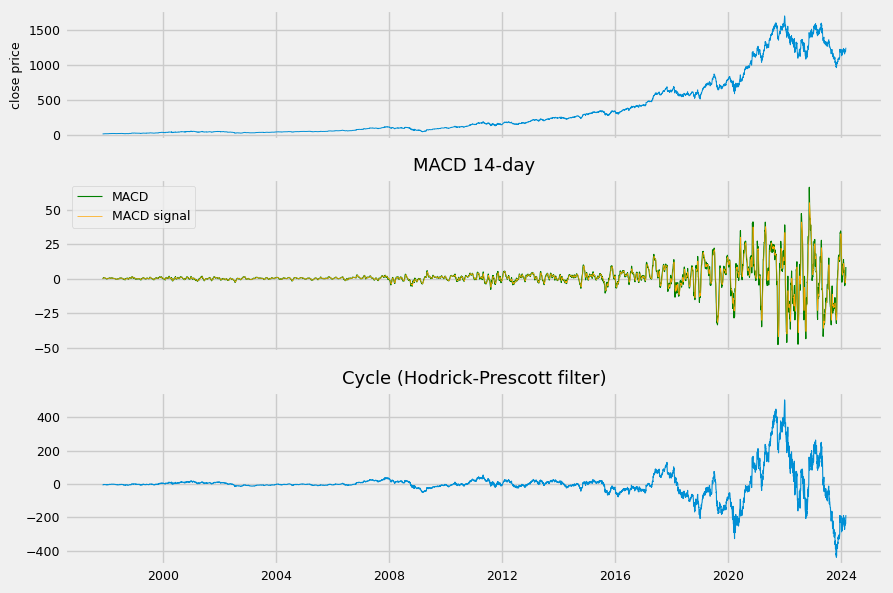

In [38]:
# MACD & cycle plot
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 2, 2]})

axes[0].plot(df['close'], linewidth=0.7)
axes[0].set_ylabel('close price')

# MACD over 14-dy window
axes[1].plot(df['macd'], color='green', label='MACD')
axes[1].plot(df['macd'].ewm(span=9, adjust=False).mean(), linewidth=0.5, color='orange', label='MACD signal')
axes[1].set_title('MACD 14-day')
axes[1].set_xlabel(None)
axes[1].legend()

# cycle
axes[2].plot(df['cycle'], label='cycle')
axes[2].set_title('Cycle (Hodrick-Prescott filter)')
axes[2].set_xlabel(None)

plt.show()

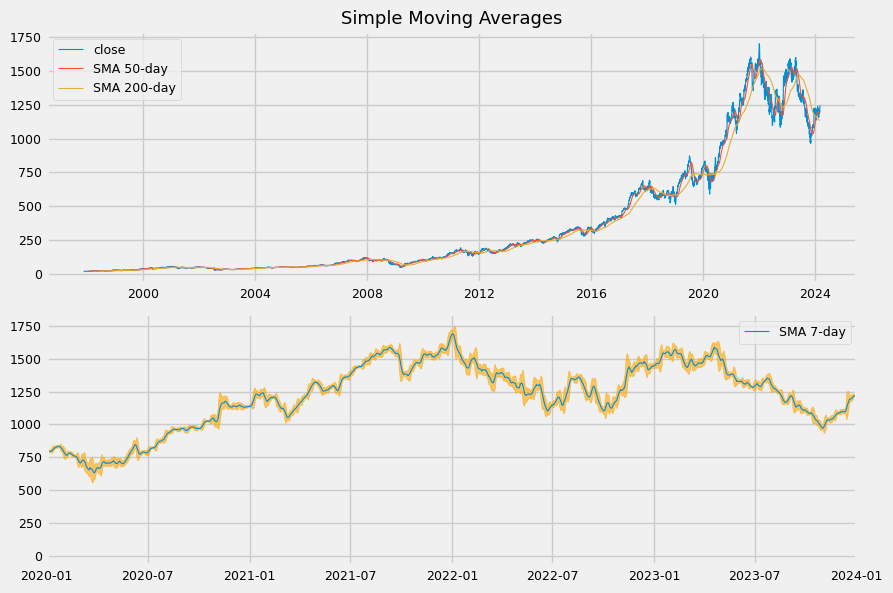

In [39]:
# simple moving averages plot
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [2, 2]})

# moving averages over 50-day & 200-day windows
axes[0].plot(df['close'], label='close')
axes[0].plot(df['close'].rolling(50).mean(), label='SMA 50-day')
axes[0].plot(df['close'].rolling(200).mean(), label='SMA 200-day')
axes[0].set_title('Simple Moving Averages')
axes[0].set_xlabel(None)
axes[0].legend()

# moving averages over a 7-day window with confidence intervals
axes[1].plot(df['sma_7'], label='SMA 7-day')
axes[1].fill_between(df.index, df['sma_7_up'], df['sma_7_low'], color='orange', alpha=0.6)
axes[1].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-01-01'))
axes[1].set_xlabel(None)
axes[1].legend()

plt.show()

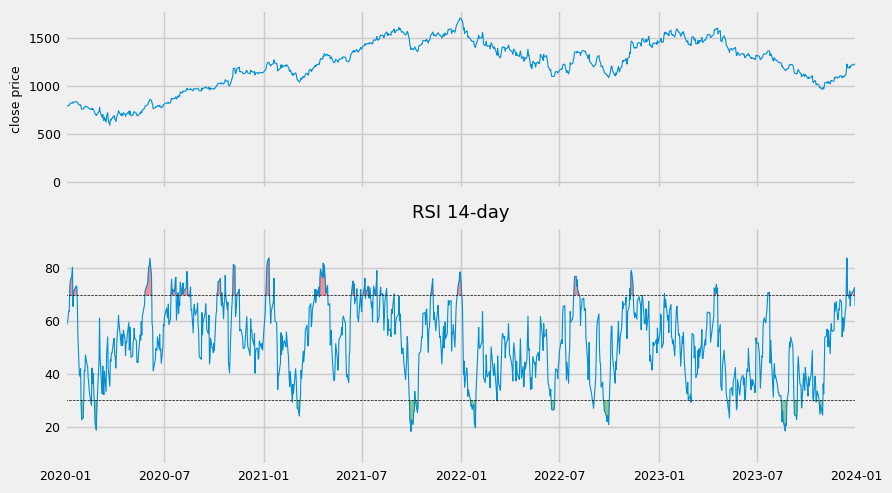

In [40]:
# RSI plot over 4-year period
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 5), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 2]})

axes[0].plot(df['close'])
axes[0].set_ylabel('close price')

axes[1].plot(df['rsi'])
axes[1].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-01-01'))
axes[1].axhline(30, linestyle='--', linewidth=0.5, color='black')
axes[1].axhline(70, linestyle='--', linewidth=0.5, color='black')
axes[1].fill_between(df.index, 70, df['rsi'], where=(70 < df['rsi']), color='red', alpha=0.4) # overbought
axes[1].fill_between(df.index, 30, df['rsi'], where=(30 > df['rsi']), color='green', alpha=0.4) # oversold
axes[1].set_title('RSI 14-day')

plt.show()

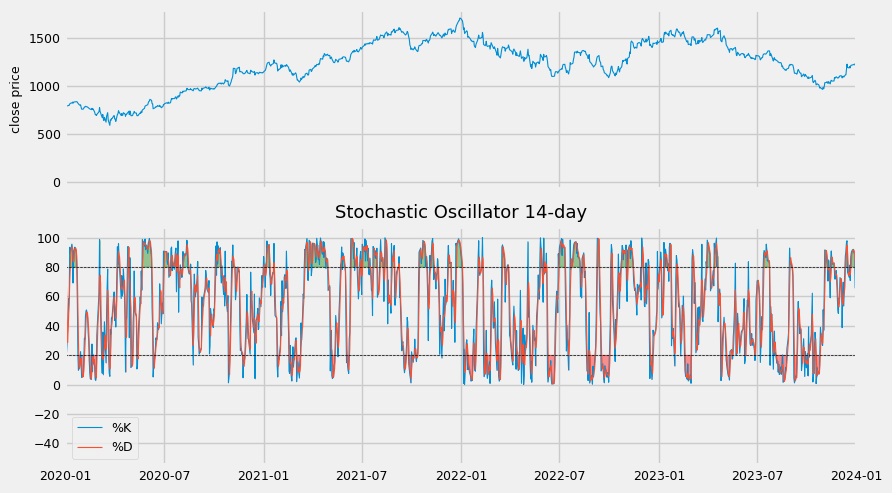

In [41]:
# stochastic oscillator plot over 4-year period
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 5), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 2]})

axes[0].plot(df['close'])
axes[0].set_ylabel('close price')

axes[1].plot(df['k'], label='%K')
axes[1].plot(df['d'], label='%D')
axes[1].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-01-01'))
axes[1].axhline(80, linestyle='--', linewidth=0.5, color='black')
axes[1].axhline(20, linestyle='--', linewidth=0.5, color='black')
axes[1].fill_between(df.index, 80, df['k'], where=(80 < df['k']), color='green', alpha=0.4) # overbought
#axes[1].axhspan(20, df['d'].min(), color='red', alpha=0.1) # oversold
axes[1].fill_between(df.index, 20, df['k'], where=(20 > df['k']), color='red', alpha=0.4) # oversold
axes[1].set_title('Stochastic Oscillator 14-day')
axes[1].legend()

plt.show()

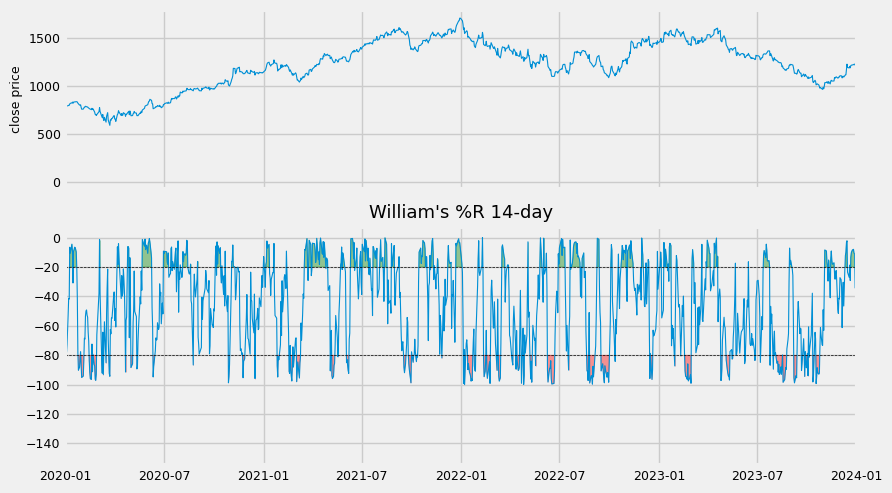

In [42]:
# William's %R plot over 4-year period
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 5), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 2]})

axes[0].plot(df['close'])
axes[0].set_ylabel('close price')

axes[1].plot(df['wr'])
axes[1].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-01-01'))
axes[1].axhline(-20, linestyle='--', linewidth=0.5, color='black')
axes[1].axhline(-80, linestyle='--', linewidth=0.5, color='black')
axes[1].fill_between(df.index, -80, df['wr'], where=(-80 > df['wr']), color='red', alpha=0.4) # overbought
axes[1].fill_between(df.index, -20, df['wr'], where=(-20 < df['wr']), color='green', alpha=0.4) # oversold
axes[1].set_title("William's %R 14-day")

plt.show()

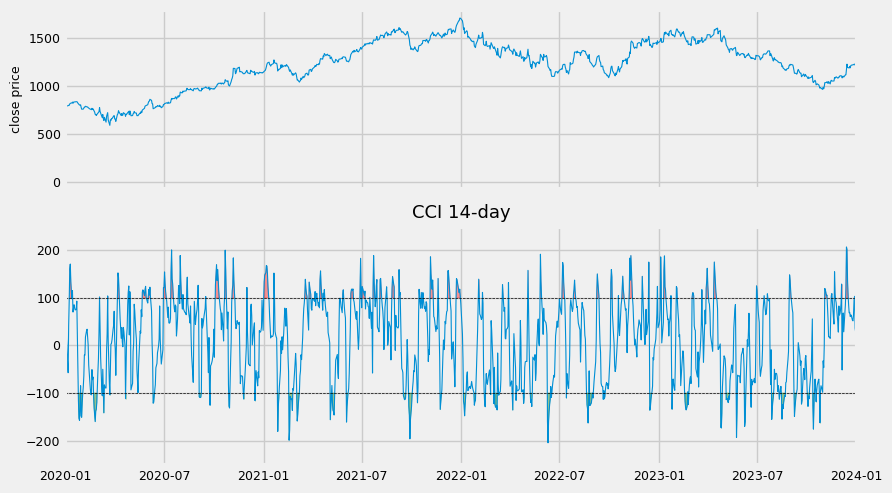

In [43]:
# CCI plot over 4-year period
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 5), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 2]})

axes[0].plot(df['close'])
axes[0].set_ylabel('close price')

axes[1].plot(df['cci'])
axes[1].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-01-01'))
axes[1].axhline(100, linestyle='--', linewidth=0.5, color='black')
axes[1].axhline(-100, linestyle='--', linewidth=0.5, color='black')
axes[1].fill_between(df.index, 100, df['cci'], where=(100 < df['cci']), color='red', alpha=0.4) # overbought
axes[1].fill_between(df.index, -100, df['cci'], where=(-100 > df['cci']), color='green', alpha=0.4) # oversold
axes[1].set_title('CCI 14-day')

plt.show()

### 5. Feature Selection

The final step is to choose the most relevant and informative features for future models and discard the ones that are not useful or redundant. This has several advantages. It can reduce model complexity, enhance learning efficiency, and can even increase predictive power by reducing noise.

All introduced features and target are continuous. We will apply correlation analysis, p-values and the mutual information method. Combining these scores will allow us to determine the variables.

In [44]:
# split dataset into features and target
X = df.loc[:, df.columns != 'close'].fillna(0)
y = df['close']

In [45]:
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_regression

# top k features
def select_kbest(k=15):
    '''
    Computes feature selection scores, correlations, p-values, and plots results.
    '''
    pearson_corr = []
    spearman_corr = []
    p_values = []

    for i in range(0, X.shape[1]):
        pearson_corr.append(pearsonr(X.iloc[:, i], y)[0])
        spearman_corr.append(spearmanr(X.iloc[:, i], y)[0])
        p_values.append(pearsonr(X.iloc[:, i], y)[1])
    
    # build feature selector
    feature_selector = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
    
    feat_scores = pd.DataFrame()
    feat_scores['Feature'] = X.columns
    feat_scores['F-score'] = feature_selector.scores_
    feat_scores['Support'] = feature_selector.get_support()
    feat_scores['Pearson'] = pearson_corr
    feat_scores['Spearman'] = spearman_corr
    feat_scores['P-value'] = p_values
    
    feat_scores.sort_values(by='F-score', ascending=False, inplace=True)
    
    return feat_scores

kbest_res = select_kbest(k=15)
kbest_res.style.hide(axis='index')

Feature,F-score,Support,Pearson,Spearman,P-value
high,4.833689,True,0.999913,0.999915,0.000000
low,4.788350,True,0.999924,0.999911,0.000000
unix,4.358478,True,0.844338,0.985617,0.000000
cum_change,4.291173,True,0.965065,0.985617,0.000000
open,4.246657,True,0.999823,0.999814,0.000000
cma_7,4.238645,True,0.969092,0.985655,0.000000
sma_7_up,4.058036,True,0.999405,0.999452,0.000000
sma_7,3.980454,True,0.999677,0.999719,0.000000
sma_7_low,3.977270,True,0.999433,0.999483,0.000000
ema_14,3.895816,True,0.999493,0.999577,0.000000


The supported features have very high F-scores meaning that they share a arbitrary large data and the dependence between random variables are significant. The technical indicators with white noise signal tend to have almost no correlation. They have means equal zero and are identically distributed. This type of feature has the same variance and no visible trends on line plots. The datetime features like: day of week, holiday, day of month, also have the lowest scores.

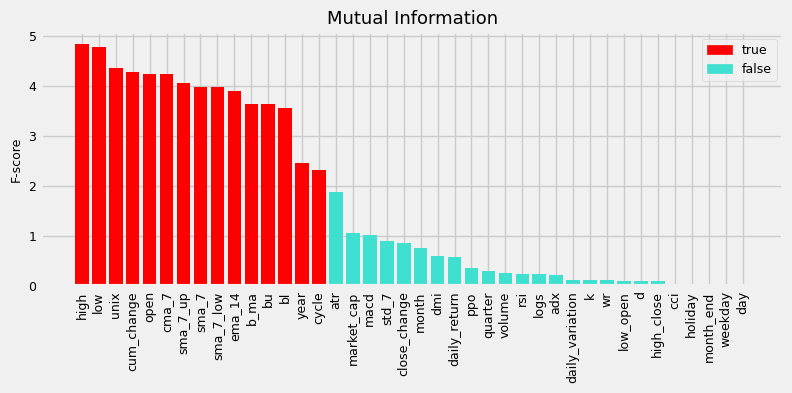

In [46]:
# mutual information results
def plot_results(data):
    '''
    Returns bar plot of scores for each feature.
    '''
    plt.figure(figsize=(8, 4), tight_layout=True)
    colors_ = ['red' if (bar == True) else 'turquoise' for bar in data['Support']]
    
    plt.bar(x=data['Feature'], height=data['F-score'], color=colors_)
    plt.title('Mutual Information')
    plt.ylabel('F-score')
    plt.xticks(rotation=90)
    
    # legend settings
    mask_colors = {'true': 'red', 'false': 'turquoise'}
    labels = list(mask_colors.keys())
    handles = [plt.Rectangle((0, 0), 1, 1, color=mask_colors[label]) for label in labels]
    plt.legend(handles, labels)
    
    plt.show()
    
plot_results(kbest_res)

In [47]:
# top percent features
def select_percentile(percentile=40):
    '''
    Computes feature selection scores, correlations, p-values, and plots results.
    '''
    pearson_corr = []
    spearman_corr = []
    p_values = []

    for i in range(0, X.shape[1]):
        pearson_corr.append(pearsonr(X.iloc[:, i], y)[0])
        spearman_corr.append(spearmanr(X.iloc[:, i], y)[0])
        p_values.append(pearsonr(X.iloc[:, i], y)[1])
    
    # build feature selector
    feature_selector = SelectPercentile(score_func=mutual_info_regression, percentile=percentile).fit(X, y)
    
    feat_scores = pd.DataFrame()
    feat_scores['Feature'] = X.columns
    feat_scores['F-score'] = feature_selector.scores_
    feat_scores['Support'] = feature_selector.get_support()
    feat_scores['Pearson'] = pearson_corr
    feat_scores['Spearman'] = spearman_corr
    feat_scores['P-value'] = p_values
    
    feat_scores.sort_values(by='F-score', ascending=False, inplace=True)
    
    return feat_scores

percentile_res = select_percentile(percentile=40)
percentile_res.style.hide(axis='index')

Feature,F-score,Support,Pearson,Spearman,P-value
high,4.834969,True,0.999913,0.999915,0.000000
low,4.788254,True,0.999924,0.999911,0.000000
unix,4.358373,True,0.844338,0.985617,0.000000
cum_change,4.290030,True,0.965065,0.985617,0.000000
open,4.245968,True,0.999823,0.999814,0.000000
cma_7,4.239023,True,0.969092,0.985655,0.000000
sma_7_up,4.057654,True,0.999405,0.999452,0.000000
sma_7,3.980209,True,0.999677,0.999719,0.000000
sma_7_low,3.977246,True,0.999433,0.999483,0.000000
ema_14,3.895843,True,0.999493,0.999577,0.000000


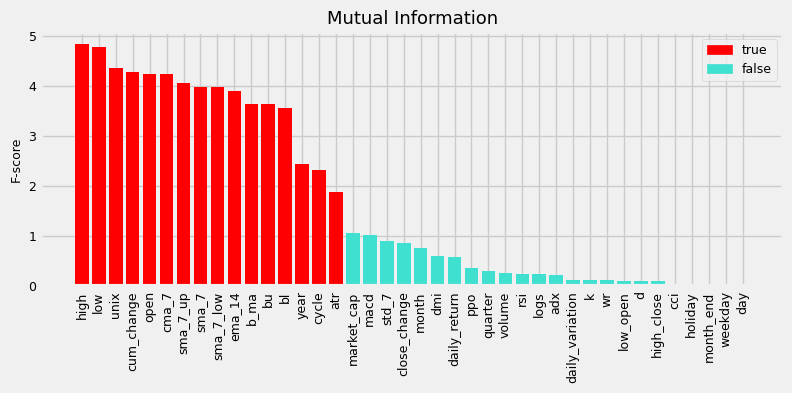

In [48]:
# plot results
plot_results(percentile_res)

These results are very similar as previous k-best selection. The percentile method returned an extra feature. In general, the features with false mask tend to have low correlation coefficients with the target price, which is what we should expect. All variables with p-value greater then 0.05 (or 5%) have false support.

Based on correlations and p-values we will choose `atr` instead of `cycle`. The `atr` variable has very strong correlation and p-value equal zero, meaning that it has real effect (the lesser the p-values the feature is best). The `cycle` feature has stronger F-score but its statistical relationships are very low. Adding it to the predicting model might introduce unnecessary noise.

In [49]:
# export variables, add 'close', and remove unwanted 'cycle'
selected_features = percentile_res.query('`Support` == True')['Feature'].tolist()
selected_features.append('close')
selected_features.remove('cycle')

# export data
df_final = df.loc[:, selected_features]
try:
    df_final.to_csv('mtd_prices.csv', index=True)
except:
    print('Something went wrong')

To be continued. Next notebooks will present time-series forecasting with diverse regression models.